In [1]:
from dataset import *
from utils import *
from data_aug import *
from tensorflow.keras import layers, models, Input
from transformers import TFViTModel
import tensorflow as tf

c:\anaconda\envs\transformers2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image1_array, image2_array, labels = load_data("data/question_1/Streetview_dataaug/")

batch_size = 16

train_generator, valid_generator, test_generator, train_size, valid_size = prepare_dataset_generators(image1_array, image2_array, labels, batch_size, "comparison")

train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

In [2]:

resize_rescale_hf = tf.keras.Sequential([
    tf.keras.layers.Permute((3, 1, 2))
])
def create_siamese_network(input_shape):
    input_1 = Input(shape=input_shape)
    resized_input_1 = resize_rescale_hf(input_1)  # Make sure resize_rescale_hf is defined or imported
    input_2 = Input(shape=input_shape)
    resized_input_2 = resize_rescale_hf(input_2)  # Make sure resize_rescale_hf is defined or imported

    # Load the ViT model for image classification
    base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

    for layer in base_model.layers:
        layer.trainable = True

    # Extract the features from the ViT model
    features_1 = base_model.vit(resized_input_1)[0][:, 0, :]
    features_2 = base_model.vit(resized_input_2)[0][:, 0, :]

    # Add dense layers with batch normalization and dropout
    merged_features = layers.Concatenate()([features_1, features_2])
    dense_layer_1 = layers.Dense(128, activation='relu')(merged_features)
    batch_norm_1 = layers.BatchNormalization()(dense_layer_1)
    dropout_1 = layers.Dropout(0.2)(batch_norm_1)

    dense_layer_2 = layers.Dense(128, activation='relu')(dropout_1)  # Adjusted to 128 units
    batch_norm_2 = layers.BatchNormalization()(dense_layer_2)
    dropout_2 = layers.Dropout(0.2)(batch_norm_2)

    # Calculate the Euclidean distance between the representations of the two images
    distance = layers.Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([dropout_1, dropout_2])
    outputs = layers.Dense(2, activation='sigmoid')(distance)

    # Create the Keras model
    siamese_network = models.Model(inputs=[input_1, input_2], outputs=outputs)
    siamese_network.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
    return siamese_network
siamese_network = create_siamese_network((224,224,3))

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [4]:
siamese_network = create_siamese_network((224,224,3))
history = siamese_network.fit(train_generator,
        steps_per_epoch=train_steps_per_epoch,
        epochs=30,
        validation_data=valid_generator,
        validation_steps=valid_steps_per_epoch)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/30
684/684 [==============================] - 502s 717ms/step - loss: 0.6534 - accuracy: 0.7266 - val_loss: 0.3854 - val_accuracy: 0.8525
Epoch 2/30
684/684 [==============================] - 487s 712ms/step - loss: 0.4138 - accuracy: 0.8443 - val_loss: 0.3059 - val_accuracy: 0.8857
Epoch 3/30
684/684 [==============================] - 489s 715ms/step - loss: 0.3471 - accuracy: 0.8726 - val_loss: 0.2550 - val_accuracy: 0.9054
Epoch 4/30
684/684 [==============================] - 489s 715ms/step - loss: 0.2917 - accuracy: 0.8992 - val_loss: 0.2020 - val_accuracy: 0.9296
Epoch 5/30
684/684 [==============================] - 489s 715ms/step - loss: 0.2359 - accuracy: 0.9266 - val_loss: 0.1656 - val_accuracy: 0.9438
Epoch 6/30
684/684 [==============================] - 489s 715ms/step - loss: 0.1882 - accuracy: 0.9458 - val_loss: 0.1119 - val_accuracy: 0.9655
Epoch 7/30
684/684 [==============================] - 489s 715ms/step - loss: 0.1464 - accuracy: 0.9625 - val_loss: 0.0891 -

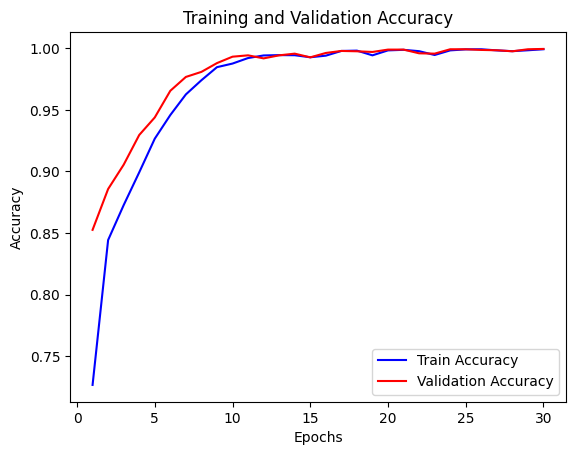

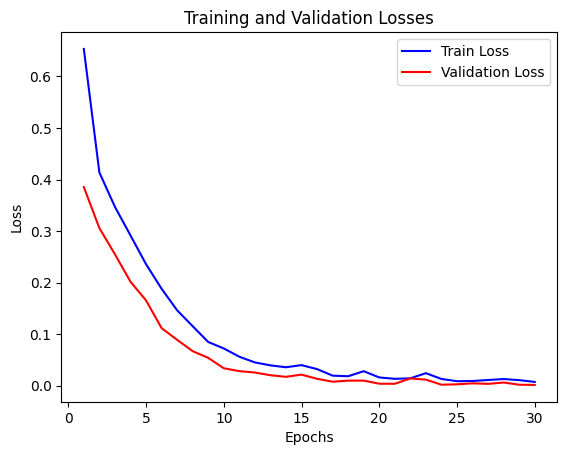

In [5]:
plot_accuracy(history)
plot_loss(history)
siamese_network.save("transformer.h5")

In [3]:
image1_array, image2_array, labels = load_data("Mapillary/mapillary_training_dataaug/")
batch_size = 16

train_generator, valid_generator, test_generator, train_size, valid_size = prepare_dataset_generators(image1_array, image2_array, labels, batch_size, "comparison")

train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

In [4]:
siamese_network.load_weights("transformer.h5")
siamese_network.evaluate(train_generator, steps=train_steps_per_epoch)

342/342 [==============================] - 81s 226ms/step - loss: 0.9282 - accuracy: 0.8573


[0.9281877875328064, 0.8572733998298645]